# Starbucks Capstone Challenge
#### A capstone project as part of my Udacity Data Scientist Nanodegree Program

###  Project Overview

The objective of this project is to do a detailed analysis of simulated data provided by Udacity (simplified version of the real Starbucks app data) that mimics customer behavior on the Starbucks rewards mobile app, along with a machine learning model that predicts whether a customer will respond to an offer. 


Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The goal here is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, it can be assumed the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Also a transactional data is provided that contains user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Problem Statement

Given the datasets below, the objective is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer reward, and to predict which users, who normally wouldn't make a purchase, would respond to a sent offer and make a purchase through it. This can be done by first answering a below questions:

1. What are the main drivers of an effective offer on the Starbucks app? 
2. What percentage of users view offers? and what are their characteristics?
3. What percentage of users respond to offers? and what percentage complete the offer after viewing it?
4. How much do adevertisements contribute in user transactions?
5. Can we predict whether a user will respond to an offer or not from demographics and offer reward?

3 classification supervised machine learning models are used to answer the questions, feeding in the data from three different offer types. 

## Metrics

The F1 score is chosen to be the metric as it defines the harmonic mean of precision and recall taking both metrics into account.

<img src="./screenshots/precision.png" width="350"/>
<img src="./screenshots/f1score.png" width="250"/>

# Data Understanding

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

%matplotlib inline

### Read the Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Lets understand each of these data sets in detail.


In [2]:
# read data from json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Understanding offer data from portfolio data set


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


Following are 3 different offer types available in the dataset.
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products


In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print("No of rows in portfolio dataset are: {} and no of columns are: {} ".format( portfolio.shape[0], portfolio.shape[1] ))

No of rows in portfolio dataset are: 10 and no of columns are: 6 


In [5]:
# check detailed info about portfolio data for no of columns, datatypes and null values
portfolio.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
#check for missing values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

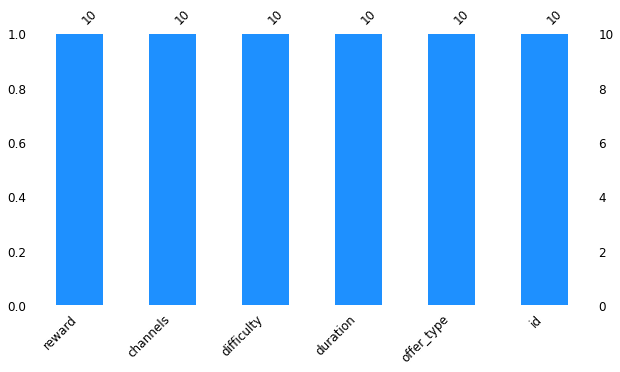

In [7]:
missingno.bar(portfolio, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [8]:
#Columns with missing values
print("Column names with missing values: \n", portfolio.columns[portfolio.isnull().sum(axis=0)>0].values)

#Total no of missing values in df_listings dataset
print("Total number of missing values are:",portfolio.isnull().sum().sum())

Column names with missing values: 
 []
Total number of missing values are: 0


In [9]:
# Check counts for each offer type
portfolio.offer_type.value_counts()
#portfolio.groupby('offer_type')['id'].count()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

#### Understanding Demographic data from profile data set

Demographic data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print("No of rows in profile dataset are: {} and no of columns are: {} ".format(  profile.shape[0], profile.shape[1]  ))

No of rows in profile dataset are: 17000 and no of columns are: 5 


In [12]:
# check detailed info about profile data for no of columns, datatypes and null values
profile.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

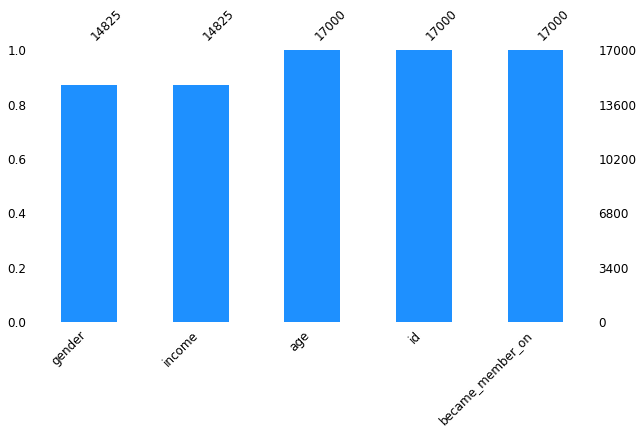

In [14]:
missingno.bar(profile, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [15]:
#Columns with missing values
print("Column names with missing values: \n", profile.columns[profile.isnull().sum(axis=0)>0].values)

#Total no of missing values in profile dataset
print("Total number of missing values are:", profile.isnull().sum().sum())

Column names with missing values: 
 ['gender' 'income']
Total number of missing values are: 4350


In [18]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

#### Understanding transcript data set

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
print("No of rows in transcript dataset are: {} and no of columns are: {} ".format(  transcript.shape[0], transcript.shape[1]  ))

No of rows in transcript dataset are: 306534 and no of columns are: 4 


In [21]:
# check detailed info about transcript data for no of columns, datatypes and null values
transcript.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

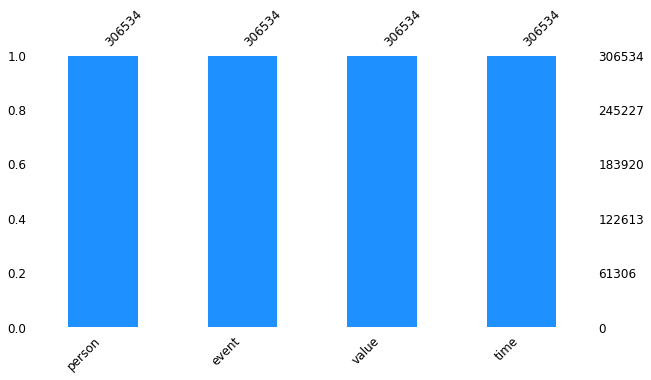

In [23]:
missingno.bar(transcript, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [24]:
#Columns with missing values
print("Column names with missing values: \n", transcript.columns[transcript.isnull().sum(axis=0)>0].values)

#Total no of missing values in transcript dataset
print("Total number of missing values are:", transcript.isnull().sum().sum())

Column names with missing values: 
 []
Total number of missing values are: 0


In [25]:
# Check counts for each event type
transcript.event.value_counts()
#transcript.groupby('event').count()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 4 unique events are available in the data set i.e. **transaction,offer received, offer viewed, offer completed**

In [27]:
#check number of unique people represented
transcript['person'].nunique()

17000

Number of people in transcript data set are the same as the number of people in the Demographics Data. This would be easy to combine the datasets 